This notebook uses `sktime`


Examples of classification; try just training a CNN versus Random Weights versus raw time series?
+ Justification: TimeNet paper suggests generic feature extractors exist


https://github.com/hfawaz/dl-4-tsc/tree/master/classifiers
https://pyts.readthedocs.io/en/stable/generated/pyts.datasets.load_basic_motions.html

In [1]:
import sys

import matplotlib.pyplot as plt
import json

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *


# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [24]:
## use basic motions dataset
from sktime.datasets import load_basic_motions
from sktime.utils.data_processing import from_nested_to_2d_array

X_train = np.array([np.array(item[0]) for item in load_basic_motions(split="train")[["dim_0"]].values])
X_train = standardize_ts(X_train)
y_train = load_basic_motions(split="train")["class_val"].to_list()

X_test = np.array([np.array(item[0]) for item in load_basic_motions(split="test")[["dim_0"]].values])
X_test = standardize_ts(X_test)
y_test = load_basic_motions(split="test")["class_val"].to_list()

In [17]:
# ?sktime.datasets.load_UCR_UEA_dataset

In [6]:
## Pre-processing: nothing, PCA, rockets, trained rockets


## Featurize: tsfresh, random convolutions, pre-trained AE
## try selecting chaotic systems with the closest power spectrum
from sktime.transformations.panel.rocket import Rocket
model = Rocket() 

In [10]:
import torch
from torch import nn

## Benchmarks: 
# tsfresh handcrafted features
# ROCKET: Random convolutional transforms followed by an aggregation operation
# What classifier to use? Just a random forest?

https://github.com/White-Link/UnsupervisedScalableRepresentationLearningTimeSeries/tree/master/networks

In [242]:
# chunk_size = 30

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from resources.causal_cnn import CausalConvolutionBlock, CausalCNNEncoder
    
class UnivariateTimeSeries(Dataset):
    """
    A dataset representation for univariate time series
    
    Args
    """
    def __init__(self, ts, seqlen):
        self.ts = torch.tensor(ts[None, :], dtype=torch.float32, requires_grad=True)
        self.seqlen = seqlen 
        
    def __len__(self):
        return self.ts.shape[-1] - self.seqlen
    
    def __getitem__(self, idx):
        input_val = self.ts[:, idx : idx+self.seqlen]
        output_val = self.ts[:, idx : idx+self.seqlen]
        
        return input_val, output_val
    
class TimeSeriesCollection(Dataset):
    """
    A dataset representation for a collection time series
    
    ts (np.ndarray): A time series dataset of shape T x D
    """
    def __init__(self, ts, seqlen):
        self.nt, self.nb = ts.shape
        self.ts = torch.tensor(ts[None, ...], dtype=torch.float32, requires_grad=True)
        self.seqlen = seqlen
        
    def __len__(self):
        return self.nb * (self.nt - self.seqlen)
    
    def __getitem__(self, idx):
        
        i, j = np.unravel_index(idx, (self.nb,  (self.nt - self.seqlen)))
        
        input_val = self.ts[:, j : j+self.seqlen, i]
        output_val = self.ts[:, j : j+self.seqlen, i]
        
        return input_val, output_val
    

class Autoencoder(nn.Module):
    """
    A simple autoencoder for time series
    """
    def __init__(self):
        super(Autoencoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Conv1d(1, 16, kernel_size=5, stride=3, padding=2),  # b, 16, 10, 10
#             nn.ELU(True),
#             nn.Conv1d(16, 8,  kernel_size=3, stride=3, padding=1),  # b, 8, 3, 3
#             nn.ELU(True),
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(8, 16, kernel_size=3, stride=1, padding=1),  # b, 16, 5, 5
#             nn.ELU(True),
#             nn.ConvTranspose1d(16, 8, kernel_size=3, stride=3, padding=1),  # b, 8, 15, 15
#             nn.ELU(True),
#             nn.ConvTranspose1d(8, 1, kernel_size=5, stride=3, padding=2),  # b, 1, 28, 28
#         )
        
        self.encoder = nn.Sequential(
            #nn.Conv1d(1, 16, kernel_size=5, stride=3, padding=2),  # b, 16, 10, 10
            CausalConvolutionBlock(1, 16, 3, 2, final=False),
#             CausalConvolutionBlock(16, 8, 3, 2, final=False),
            nn.Conv1d(16, 8,  kernel_size=3, stride=3, padding=1),  # b, 8, 3, 3
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, kernel_size=3, stride=1, padding=1),  # b, 16, 5, 5
            nn.ELU(True),
            nn.ConvTranspose1d(16, 8, kernel_size=3, stride=3, padding=1),  # b, 8, 15, 15
            nn.ELU(True),
            nn.ConvTranspose1d(8, 1, kernel_size=3, stride=1, padding=1),  # b, 1, 28, 28
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    

    
from dysts.flows import Lorenz

model = Lorenz()

sol = model.make_trajectory(1000, resample=True)

model = Autoencoder()
print(inputs.shape)
print(model.encoder(inputs).shape)
print(model(inputs).shape)

torch.Size([4, 1, 100])
torch.Size([4, 8, 34])
torch.Size([4, 1, 100])


In [236]:
sol.shape

(1000,)

In [233]:
np.unravel_index(90, (7,  (100 - 10)))

(1, 0)

In [226]:
np.ravel_multi_index(0, (7,  (100 - 10)))

TypeError: dispatcher for __array_function__ did not return an iterable

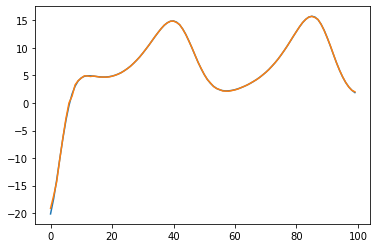

In [243]:


    
# training_data = UnivariateTimeSeries(sol[:, 0], 100)
training_data = TimeSeriesCollection(sol, 100)






model = Autoencoder()
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, outputs = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(inputs, outputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
plt.plot(inputs[0, 0, :].detach().numpy())
plt.plot(outputs[0, 0, :].detach().numpy())

In [ ]:
## Batchwise training classifier
## Baseline is usually 1-NN with DTW
## But really need an NN where we can pre-train
## ROCKET vs trained convolutional?



## Or, unsupervised learning on a bunch of chaotic ssytems
## then train a classifier on the encoder outputs for new data

Classifier: logistic regression and Adam OR Ridge Regression



In [ ]:
import sktime.datasets
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sklearn.linear_model import RidgeClassifierCV

cwd = os.getcwd()
# cwd = os.path.dirname(os.path.realpath(__file__))
output_path = cwd + "/results/transfer_learning.json"
print("Saving data to: ", output_path)

dataset_names = np.genfromtxt("./resources/ucr_ea_names.txt", dtype='str')

all_scores = dict()
for name in dataset_names:
    all_scores[name] = dict()
    X_train, y_train = sktime.datasets.load_UCR_UEA_dataset(name, split="train", return_X_y=True)
    X_test, y_test = sktime.datasets.load_UCR_UEA_dataset(name, split="test", return_X_y=True)
    
    transformer = TSFreshFeatureExtractor()
    X_train_featurized = transformer.fit_transform(X_train)
    X_test_featurized = transformer.fit_transform(X_test)

    model = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)
    model.fit(X_train_featurized, y_train)

    score = model.score(X_test_featurized, y_test)
    all_scores[name]["score_tsfresh"] = model.score(X_test_featurized, y_test)

    print(name, score, flush=True)
    
    with open(output_path, 'w') as file:
        json.dump(all_scores, file, indent=4)
    

Saving data to:  /Users/williamgilpin/program_repos/dysts/benchmarks/results/transfer_learning.json


Feature Extraction: 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [00:25<00:00,  5.12s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['dim_0__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


ACSF1 0.77


Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]

In [248]:
from dysts.utils import find_significant_frequencies

from sktime.utils.data_processing import from_nested_to_3d_numpy, from_3d_numpy_to_nested

X_train_np = from_nested_to_3d_numpy(X_train)
X_test_np = from_nested_to_3d_numpy(X_test)

all_freqs = list()
for row in X_train_np:
    freqs, amps = find_significant_frequencies(row[0], return_amplitudes=True)
    sort_inds = np.argsort(amps)[::-1]
    freqs, amps = freqs[sort_inds], amps[sort_inds]
    all_freqs.append(freqs[0])
main_freq = np.median(all_freqs)
main_period = 2 * 1/main_freq

all_sols = list()
for equation_ind, equation_name in enumerate(get_attractor_list()):
    equation = getattr(dysts.flows, equation_name)()
    sol = equation.make_trajectory(1000, resample=True, pts_per_period=int(main_period))
    all_sols.append(standardize_ts(sol)[:, 0])
    if equation_ind > 5:
        print("stopped at index")
        break
all_sols = np.array(all_sols).T
# plt.plot(all_sols[:100]);

# plt.plot(row[0][:300])
# plt.plot(sol[:300, 0]/5)




/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:166: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/base.py:166: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn("This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.")
/Users/williamgilpin/miniconda3/envs/dys

stopped at index


In [255]:
training_data = TimeSeriesCollection(all_sols, 100)

model = Autoencoder()
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, outputs = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(inputs, outputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

In [298]:
X_train_nn = from_3d_numpy_to_nested(model.encoder(torch.tensor(X_train_np, dtype=torch.float32)).detach().numpy())
X_test_nn = from_3d_numpy_to_nested(model.encoder(torch.tensor(X_test_np, dtype=torch.float32)).detach().numpy())

transformer = TSFreshFeatureExtractor()
X_train_featurized = transformer.fit_transform(X_train_nn)
X_test_featurized = transformer.fit_transform(X_test_nn)

model = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)
model.fit(X_train_featurized, y_train)

score = model.score(X_test_featurized, y_test)

Feature Extraction: 100%|██████████| 5/5 [02:55<00:00, 35.04s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['var_0__fft_coefficient__attr_"real"__coeff_51'
 'var_0__fft_coefficient__attr_"real"__coeff_52'
 'var_0__fft_coefficient__attr_"real"__coeff_53' ...
 'var_7__fft_coefficient__attr_"angle"__coeff_98'
 'var_7__fft_coefficient__attr_"angle"__coeff_99'
 'var_7__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████| 5/5 [02:47<00:00, 33.41s/it]
/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['var_0__fft_coefficient__attr_"real"__coeff_51'
 'var_0__fft_coefficient__attr_"real"__coeff_52'
 'var_0__fft_coefficien

In [301]:
score

0.6102564102564103

In [299]:
score

0.6282051282051282

In [297]:
X_train_nn)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7
0,0 -1.045549 1 -1.185358 2 -1.000528 3...,0 0.148564 1 0.524387 2 0.416969 3...,0 -0.308031 1 -0.952667 2 -0.993770 3...,0 1.037275 1 1.139595 2 0.856233 3...,0 0.542924 1 0.831971 2 0.602963 3...,0 0.527383 1 1.270000 2 1.276315 3...,0 0.629878 1 0.189812 2 0.439987 3...,0 -0.162789 1 0.281756 2 0.543367 3...
1,0 -1.206776 1 -1.241949 2 -0.760766 3...,0 0.267801 1 0.377145 2 0.613703 3...,0 -0.381799 1 -1.140368 2 -0.656760 3...,0 1.250660 1 1.172733 2 0.512608 3...,0 0.737092 1 0.866945 2 0.360313 3...,0 0.682091 1 1.404548 2 1.021273 3...,0 0.396572 1 0.252289 2 0.550952 3...,0 -0.247439 1 0.490853 2 0.389029 3...
2,0 0.049804 1 -0.009496 2 -0.232796 3...,0 0.679538 1 0.463804 2 0.344650 3...,0 0.769708 1 1.001717 2 0.458595 3...,0 -0.626459 1 -0.148588 2 0.147706 3...,0 -0.585258 1 -0.376136 2 -0.192336 3...,0 -0.204803 1 -0.751950 2 -0.294768 3...,0 1.349125 1 1.063873 2 0.976488 3...,0 -0.229302 1 -0.846248 2 -0.478211 3...
3,0 -0.991080 1 -0.961166 2 -0.894935 3...,0 0.134388 1 0.365111 2 0.463720 3...,0 -0.272047 1 -0.650026 2 -0.699576 3...,0 0.962055 1 0.916741 2 0.796498 3...,0 0.481211 1 0.571132 2 0.505261 3...,0 0.481582 1 0.833098 2 0.973887 3...,0 0.691561 1 0.470084 2 0.481187 3...,0 -0.146556 1 0.137433 2 0.259968 3...
4,0 -0.175037 1 -0.132690 2 -0.264104 3...,0 0.483296 1 0.344647 2 0.286750 3...,0 0.509804 1 0.689456 2 0.466997 3...,0 -0.264451 1 0.004228 2 0.220129 3...,0 -0.364079 1 -0.268277 2 -0.155716 3...,0 -0.069723 1 -0.521530 2 -0.340714 3...,0 1.249395 1 1.062690 2 0.963337 3...,0 -0.175281 1 -0.616859 2 -0.531657 3...
...,...,...,...,...,...,...,...,...
385,0 -0.015794 1 -0.005064 2 -0.163799 3...,0 0.653103 1 0.340941 2 0.256193 3...,0 0.707100 1 0.876890 2 0.625395 3...,0 -0.527750 1 -0.145082 2 0.112195 3...,0 -0.517386 1 -0.400832 2 -0.258077 3...,0 -0.160217 1 -0.702895 2 -0.512268 3...,0 1.303556 1 1.156822 2 1.037013 3...,0 -0.227488 1 -0.703360 2 -0.613494 3...
386,0 -0.926261 1 -0.684305 2 -0.846801 3...,0 -0.084608 1 0.553728 2 0.369492 3...,0 -0.313994 1 -0.344021 2 -0.474402 3...,0 0.911013 1 0.502584 2 0.846717 3...,0 0.383457 1 0.282490 2 0.453499 3...,0 0.391388 1 0.609813 2 0.672877 3...,0 0.878217 1 0.615082 2 0.542559 3...,0 -0.036607 1 0.069720 2 0.007655 3...
387,0 -0.092368 1 -0.146139 2 -0.183954 3...,0 0.644357 1 0.425007 2 0.295079 3...,0 0.643501 1 0.720289 2 0.561207 3...,0 -0.417479 1 0.011067 2 0.115472 3...,0 -0.435760 1 -0.246566 2 -0.237080 3...,0 -0.104457 1 -0.501388 2 -0.425611 3...,0 1.238543 1 1.010241 2 1.025866 3...,0 -0.235378 1 -0.664617 2 -0.561674 3...
388,0 -0.689760 1 -0.668483 2 -0.615910 3...,0 0.424884 1 0.416499 2 0.344719 3...,0 0.083339 1 -0.218104 2 -0.252719 3...,0 0.475233 1 0.583587 2 0.536624 3...,0 0.184752 1 0.268030 2 0.195182 3...,0 0.301442 1 0.420553 2 0.426795 3...,0 0.816409 1 0.693562 2 0.766236 3...,0 -0.224868 1 -0.085310 2 -0.002331 3...


In [291]:
X_train_nn.shape

torch.Size([390, 8, 100])

In [290]:
X_train_np.shape

(390, 1, 300)

In [279]:
model.encoder(inputs).shape

torch.Size([28, 8, 34])

In [277]:
X_train_np.shape

(390, 1, 300)

In [268]:
torch.tensor(X_train_np, dtype=torch.float32)

torch.Size([390, 1, 300])

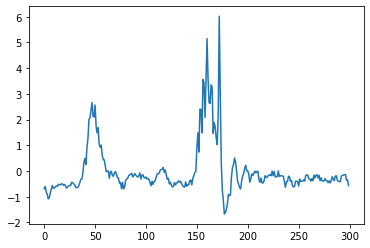

In [285]:
plt.plot(X_train_np[0, :, :].T);

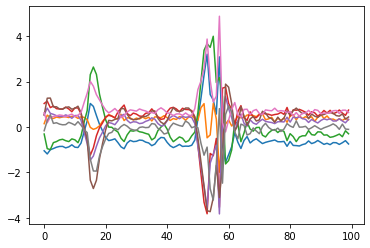

In [284]:
plt.plot(X_train_featts.detach().numpy()[0, :, :].T);

In [254]:
all_sols.shape

(1000, 7)

In [203]:
sol.shape

(1000, 3)

In [181]:
main_freq

0.5

/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


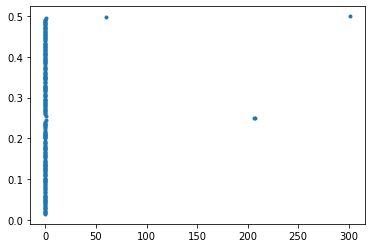

In [173]:
plt.plot(freqs, amps,  '.')

In [48]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

X_train, y_train = load_basic_motions(split="train", return_X_y=True)
X_test, y_test = load_basic_motions(split="test", return_X_y=True)

X_train, y_train = sktime.datasets.load_UCR_UEA_dataset("AbnormalHeartbeat", split="train", return_X_y=True)
X_test, y_test = sktime.datasets.load_UCR_UEA_dataset("AbnormalHeartbeat", split="test", return_X_y=True)

transformer = TSFreshFeatureExtractor()
X_train_featurized = transformer.fit_transform(X_train)
X_test_featurized = transformer.fit_transform(X_test)


from sklearn.linear_model import RidgeClassifierCV

model = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)
model.fit(X_train_featurized, y_train)

model.score(X_test_featurized, y_test)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/sktime/datasets/data/AbnormalHeartbeat/AbnormalHeartbeat_TRAIN.ts'

In [38]:
X_train_featurized = extracted_features

1.0

In [44]:
model.predict(X_test_featurized)

array(['standing', 'standing', 'standing', 'standing', 'standing',
       'standing', 'standing', 'standing', 'standing', 'standing',
       'running', 'running', 'running', 'running', 'running', 'running',
       'running', 'running', 'running', 'running', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton'], dtype='<U9')

In [45]:
y_test

array(['standing', 'standing', 'standing', 'standing', 'standing',
       'standing', 'standing', 'standing', 'standing', 'standing',
       'running', 'running', 'running', 'running', 'running', 'running',
       'running', 'running', 'running', 'running', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton', 'badminton', 'badminton', 'badminton',
       'badminton', 'badminton'], dtype='<U9')

### Load datasets

In [ ]:
from sktime.utils.data_io import load_from_tsfile_to_dataframe


BASE_PATH = "./resources/ucr_univariate_ts"
dataset_names = np.genfromtxt("./resources/ucr_ea_names.txt", dtype='str')

for name in dataset_names:

    X_train, y_train = load_from_tsfile_to_dataframe(
        os.path.join(BASE_PATH, name + "/" + name + "_TRAIN.ts")
    )
    
    X_test, y_test = load_from_tsfile_to_dataframe(
        os.path.join(BASE_PATH, name + "/" + name + "_TEST.ts")
    )

    break
